In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from ase.lattice.hexagonal import Graphite
from pyqstem.util import atoms_plot
from pyqstem import PyQSTEM
from pyqstem.potentials import poisson_solver,create_potential_slices
from pyqstem.imaging import CTF
mpl.rc('font',**{'size' : 13})

This notebook demonstrates how to use nested loops to optimize multiple simulation parameters at the same time. The notebook approximately reproduces some results from the paper: https://doi.org/10.1016/j.ultramic.2011.10.009.

<IPython.core.display.Javascript object>


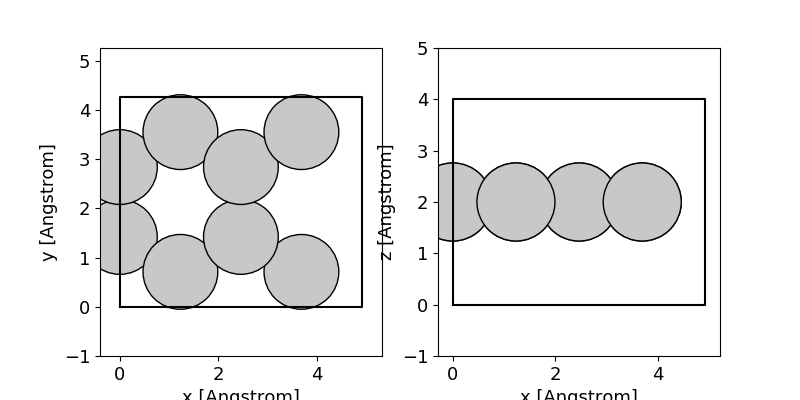

In [2]:
directions=[[1,-2,1,0],[2,0,-2,0],[0,0,0,1]] # QSTEM requires a right-angled unit cell
atoms = Graphite(symbol='C', latticeconstant={'a':2.46,'c':6.70}, directions=directions, size=(2,1,1))

del atoms[atoms.get_positions()[:,2]<atoms.get_cell()[2,2]/2] # delete the one of the layers in the graphite unit cell

atoms.wrap()
atoms.center(vacuum=2,axis=2)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
atoms_plot(atoms,direction=2,ax=ax1)
atoms_plot(atoms,direction=1,ax=ax2)

In [4]:
qstem=PyQSTEM('TEM')
qstem.set_atoms(atoms)
v0=80
qstem.build_wave('plane',v0,(100,100))
qstem.build_potential(10)
qstem.run()
wave=qstem.get_wave()

<IPython.core.display.Javascript object>


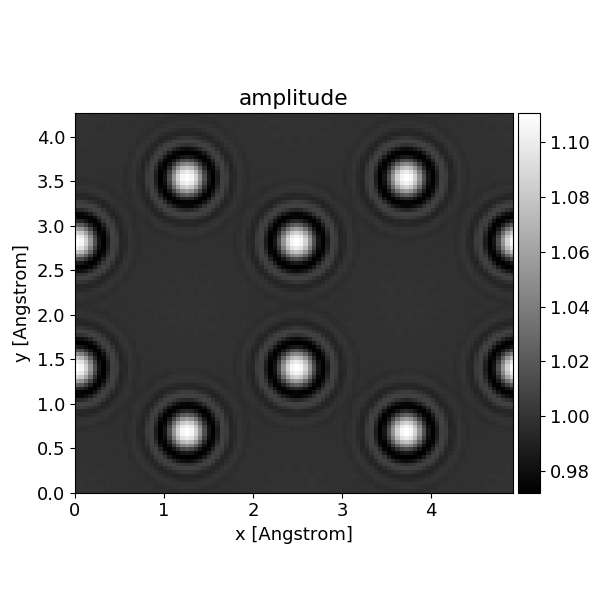

In [5]:
wave.view(method='amplitude')

In [6]:
Cs_list=np.linspace(-20*10**4,20*10**4,9)
defocus_list=np.linspace(-100,100,21)

img_dict={}
for defocus in defocus_list:
    for Cs in Cs_list:
        ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=40)
        img_dict[(defocus,Cs)]=wave.apply_ctf(ctf).detect()

<IPython.core.display.Javascript object>


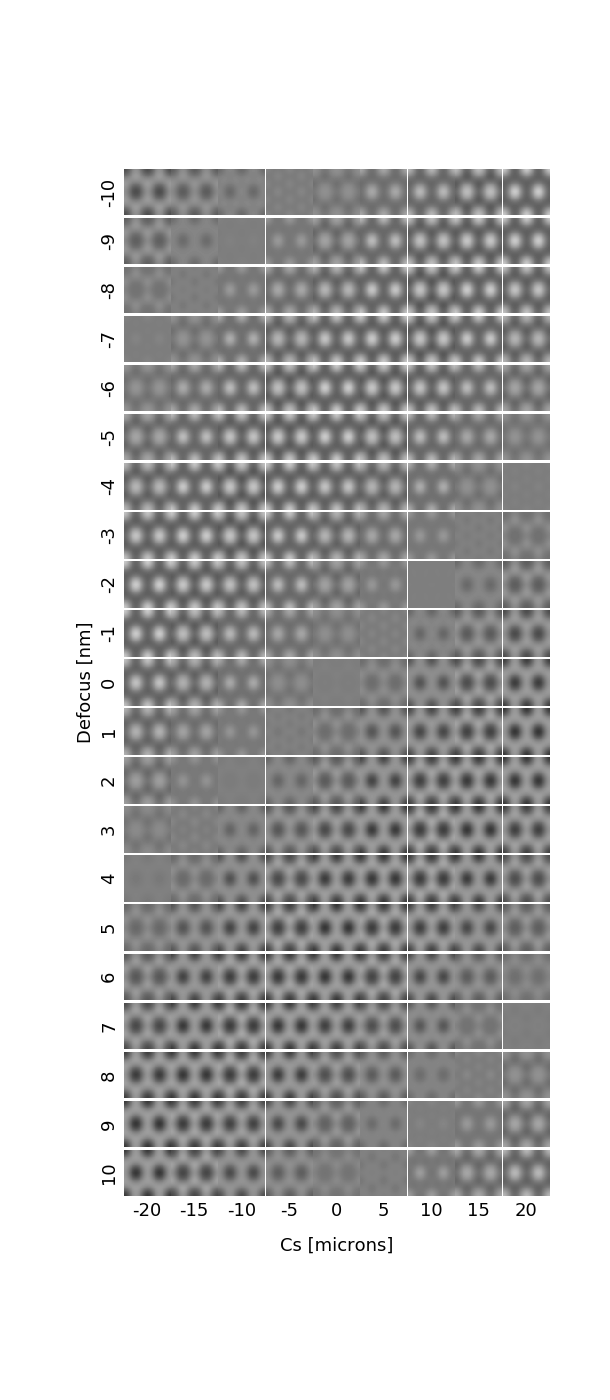

In [7]:
fig = plt.figure(figsize=(6.1,14))
gs = gridspec.GridSpec(len(defocus_list)+1,len(Cs_list)+1)

gs.update(wspace=.02, hspace=.02)

ax=plt.subplot(gs[:-1,0])
ax.text(0.2, 0.5, 'Defocus [nm]', va='center', ha='center', rotation='vertical')
ax.axis('off')

ax=plt.subplot(gs[-1,1:])
ax.text(0.5, 0, 'Cs [microns]', va='center', ha='center', rotation='horizontal')
ax.axis('off')

for i,defocus in enumerate(defocus_list[:]):
    for j,Cs in enumerate(Cs_list):
        ax=plt.subplot(gs[i,j+1])
        ax.imshow(img_dict[(defocus,Cs)].T,cmap='gray',interpolation='nearest',vmin=.8,vmax=1.2)
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        
        if i==len(defocus_list)-1:
            ax.set_xlabel('{0:.0f}'.format(Cs/10**4))
        
        if j==0:
            ax.set_ylabel('{0:.0f}'.format(defocus/10))

plt.savefig('image_mosaic.png',dpi=150,bbox_inches='tight')